In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
from IPython.display import display, HTML
from scipy.stats.mstats import gmean
from pprint import pprint
import matplotlib.pyplot as plt
import os, re, sys, glob

plt.rcParams['figure.max_open_warning'] = 50
display(HTML("<style>.container { width:100% !important; }</style>"))

sys.path.insert(0, os.getcwd() + "/../../")
from analysis.utils import PM_HOME
from analysis.trace_utils import *

### DLRM

In [7]:
# Automatically get errors from logs
batch_sizes = [512, 1024, 2048, 4096]
num_gpus = 1
trimmed_iters = 30
gpus = ["V100", "Xp", "P100"]
models = ["DLRM_default", "DLRM_MLPerf", "DLRM_DDP"]
errors = {}
actual_time = {}
for gpu in gpus:
    errors[gpu] = {}
    actual_time[gpu] = {}
    for model in models:
        errors[gpu][model] = []
        actual_time[gpu][model] = []
        for batch_size in batch_sizes:
            log_file = '{}/data/{}/e2e/{}/b/{}_{}.log'.format(PM_HOME, gpu, model, num_gpus, batch_size, trimmed_iters)
            assert os.path.exists(log_file), "{} does not exist".format(log_file)
            for line in open(log_file, 'r'):
                if re.search("Overall per-batch training time", line):
                    actual_time[gpu][model].append(float(line.split(' ')[4])) # In us
            prediction_file = '{}/data/{}/e2e/{}/b/{}_{}_prediction_{}.log'.format(PM_HOME, gpu, model, num_gpus, batch_size, trimmed_iters)
            assert os.path.exists(prediction_file), "{} does not exist".format(prediction_file)
            for line in open(prediction_file, 'r'):
                if re.search("Prediction error:", line):
                    active_error = float(line.split(' ')[2].rstrip(',').rstrip('%'))
                    e2e_error = float(line.split(' ')[3].rstrip(',').rstrip('%'))
                    kernel_only_error = float(line.split(' ')[4].rstrip(',').rstrip('%'))
                    errors[gpu][model].append([active_error, e2e_error, kernel_only_error])
            shared_prediction_file = '{}/data/{}/e2e/{}/b/{}_{}_prediction_{}_shared.log'.format(PM_HOME, gpu, model, num_gpus, batch_size, trimmed_iters)
            if os.path.exists(shared_prediction_file):
                for line in open(shared_prediction_file, 'r'):
                    if re.search("Prediction error:", line):
                        shared_e2e_error = float(line.split(' ')[3].rstrip(',').rstrip('%'))
                        errors[gpu][model][-1].append(shared_e2e_error)


In [132]:
# # Manually input all the stats
# batch_sizes = [512, 1024, 2048, 4096]
# errors = {
#     "V100": {
#         "DLRM_default": [[8.73, -12.68, -41.16], [6.85, -21.48, -24.51], [2.57, -12.39, -14.57], [4.88, -3.19, -4.48]],
#         "DLRM_MLPerf": [[2.10, 11.20, -44.90], [5.15, -5.49, -30.72], [2.56, -13.73, -18.50], [-0.45, -8.25, -10.19]],
#         "DLRM_DDP": [[10.41, 6.99, -63.26], [10.63, -1.32, -52.70], [7.78, -3.77, -34.38], [8.64, -11.95, -18.53]],
#     },
#     "Titan XP": {
#         "DLRM_default": [[6.63, -3.38, -39.63], [-10.56, -18.24, -20.72], [8.46, -7.58, -9.23], [9.53, 0.70, -0.26]],
#         "DLRM_MLPerf": [[-4.36, 6.34, -55.65], [-3.09, 6.09, -35.51], [9.71, -14.32, -26.22], [12.07, -16.26, -19.00]],
#         "DLRM_DDP": [[-3.56, -6.69, -71.52], [0.56, -0.53, -54.89], [3.90, -17.59, -37.38], [4.07, -22.75, -24.74]],
#     },
#     "P100": {
#         "DLRM_default": [[11.34, 13.5, -32.89], [3.77, -20.40, -29.08], [-7.00, -18.20, -19.89], [-4.36, -11.49, -12.48]],
#         "DLRM_MLPerf": [[18.35, 5.20, -41.52], [13.48, 6.66, -19.89], [7.61, -5.88, -11.79], [7.19, -2.20, -4.57]],
#         "DLRM_DDP": [[23.53, 18.66, -53.95], [2.53, 15.85, -41.44], [-0.38, -13.00, -28.47], [-9.55, -21.2, -23.19]],
#     }
# }

In [9]:
# Overall
overall_active = [abs(c[0]) for device in errors.keys() for model in errors[device].keys() for c in errors[device][model]]
overall_total = [abs(c[1]) for device in errors.keys() for model in errors[device].keys() for c in errors[device][model]]
error_active_devices = {
    device: [abs(c[0]) for model in errors[device].keys() for c in errors[device][model]] for device in errors.keys()
}
error_total_devices = {
    device: [abs(c[1]) for model in errors[device].keys() for c in errors[device][model]] for device in errors.keys()
}

# print("Overall GPU (geo, min, max): {:.2f} & {:.2f} & {:.2f}".format(gmean(overall_active), min(overall_active), max(overall_active)))
# print("Overall total (geo, min, max): {:.2f} & {:.2f} & {:.2f}".format(gmean(overall_total), min(overall_total), max(overall_total)))

# for device in error_active_devices.keys():
#     print("{} GPU (geo, min, max): {:.2f} & {:.2f} & {:.2f}".format(device, gmean(error_active_devices[device]), min(error_active_devices[device]), max(error_active_devices[device])))
#     print("{} total (geo, min, max): {:.2f} & {:.2f} & {:.2f}".format(device, gmean(error_total_devices[device]), min(error_total_devices[device]), max(error_total_devices[device])))


overall_shared_total = [abs(c[3]) for device in errors.keys() for model in errors[device].keys() for c in errors[device][model]]
error_shared_total_devices = {
    device: [abs(c[3]) for model in errors[device].keys() for c in errors[device][model]] for device in errors.keys()
}

# print("Active & \bf{:.2f}\% & {:.2f}\% & {:.2f}\%".format(gmean(overall_active), min(overall_active), max(overall_active)))
# print("E2E & \bf{:.2f}\% & {:.2f}\% & {:.2f}\%".format(gmean(overall_total), min(overall_total), max(overall_total)))
# print("Shared E2E & \bf{:.2f}\% & {:.2f}\% & {:.2f}\%".format(gmean(overall_shared_total), min(overall_shared_total), max(overall_shared_total)))

# For Latex
s1 = ["Active & \\bf{:.2f}\% & {:.2f}\% & {:.2f}\%".format(gmean(overall_active), min(overall_active), max(overall_active))]
s2 = ["E2E & \\bf{:.2f}\% & {:.2f}\% & {:.2f}\%".format(gmean(overall_total), min(overall_total), max(overall_total))]
s3 = ["Shared E2E & \\bf{:.2f}\% & {:.2f}\% & {:.2f}\%".format(gmean(overall_shared_total), min(overall_shared_total), max(overall_shared_total))]
for device in error_active_devices.keys():
    s1.append("{:.2f}\% & {:.2f}\% & {:.2f}\%".format(gmean(error_active_devices[device]), min(error_active_devices[device]), max(error_active_devices[device])))
    s2.append("{:.2f}\% & {:.2f}\% & {:.2f}\%".format(gmean(error_total_devices[device]), min(error_total_devices[device]), max(error_total_devices[device])))
    s3.append("{:.2f}\% & {:.2f}\% & {:.2f}\%".format(gmean(error_shared_total_devices[device]), min(error_shared_total_devices[device]), max(error_shared_total_devices[device])))
print(' & '.join(s1) + "\\\\")
print(' & '.join(s2) + "\\\\")
print(' & '.join(s3) + "\\\\")

Active & \bf4.61\% & 0.41\% & 15.25\% & 2.69\% & 0.41\% & 7.82\% & 5.73\% & 1.18\% & 11.04\% & 6.37\% & 1.99\% & 15.25\%\\
E2E & \bf7.96\% & 0.09\% & 24.92\% & 7.56\% & 0.73\% & 21.96\% & 6.97\% & 0.09\% & 24.92\% & 9.59\% & 2.04\% & 22.76\%\\
Shared E2E & \bf10.15\% & 0.75\% & 28.38\% & 6.92\% & 0.75\% & 20.79\% & 12.52\% & 1.13\% & 26.17\% & 12.09\% & 1.06\% & 28.38\%\\


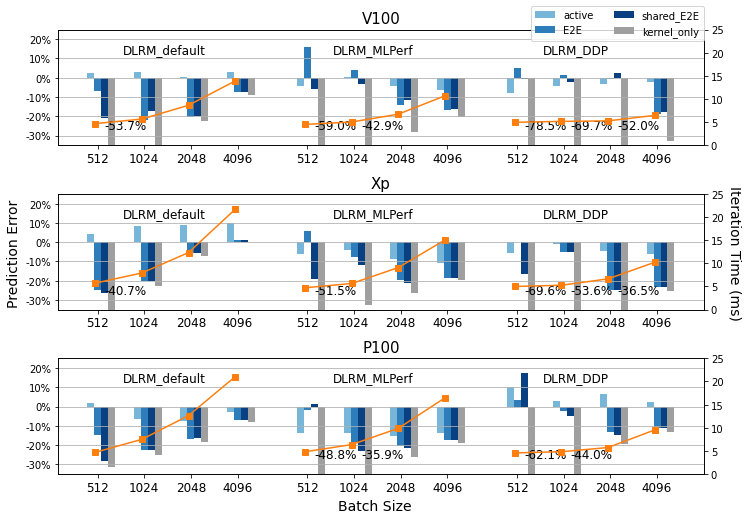

In [15]:

batch_sizes = [512, 1024, 2048, 4096]
fig, axes = plt.subplots(nrows=len(gpus), ncols=1, figsize=(10, 7))
count = 0
model_gap = 4.5
yticks = [-30, -20, -10, 0, 10, 20]
yticks2 = [0, 5, 10, 15, 20, 25]
yticklabels = ["{:.0f}%".format(x) for x in yticks]
for device, error in errors.items():
    ax = axes[count]
    ax2 = ax.twinx()
    e1 = []
    e2 = []
    eb = []
    e3 = []
    x1 = []
    x2 = []
    xb = []
    x3 = []
    xt = []
    yt = []
    c = 0
    for model, e in error.items():
        xtt = []
        ytt = []
        c += 1
        cc = 0
        for idx, ee in enumerate(e):
            e1.append(ee[0])
            e2.append(ee[1])
            eb.append(ee[2])
            if len(ee) == 4:
                e3.append(ee[3])
                x1.append(model_gap * c - 2 + cc - 0.3)
                x2.append(model_gap * c - 2 + cc - 0.15)
                x3.append(model_gap * c - 2 + cc)
                xb.append(model_gap * c - 2 + cc + 0.15)
            else:
                x1.append(model_gap * c - 2 + cc - 0.15)
                x2.append(model_gap * c - 2 + cc)
                xb.append(model_gap * c - 2 + cc + 0.15)
            cc += 1

            xtt.append(model_gap * c - 2 + cc - 1.2)

        ax.text(model_gap * c - 1.6, 13, model, fontsize=12, transform=ax.transData)

        ax2.plot(xtt, actual_time[device][model], color=plt.get_cmap("tab10")(1), marker="s")

    ax.bar(x1, e1, width=0.15, color=plt.get_cmap("Blues")(120), label='active')
    ax.bar(x2, e2, width=0.15, color=plt.get_cmap("Blues")(180), label='E2E')
    if e3:
        ax.bar(x3, e3, width=0.15, color=plt.get_cmap("Blues")(240), label='shared_E2E')
    ax.bar(xb, eb, width=0.15, color=plt.get_cmap("Greys")(120), label='kernel_only')
    ax.grid(axis='y')
    ax.set_xticks([(x+y)/2 for x,y in zip(x1,x3)])
    ax.set_xticklabels(batch_sizes + batch_sizes + batch_sizes, fontsize=12)
    ax.set_title(device, fontsize=15)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylim(yticks[0]-5, yticks[-1]+5)
    xes = [zip(x1, e1), zip(x2, e2), zip(xb, eb)]
    if e3:
        xes.insert(-2, zip(x3, e3))
    for xe in xes:
        for x, e in xe:
            if e < yticks[0]-5:
                ax.text(x+0.3, yticks[0]+5, "{:.1f}%".format(e), horizontalalignment='center', verticalalignment='center', size=12)

    ax2.set_yticks(yticks2)

    count += 1
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc=[0.71, 0.92], ncol=2)
fig.text(-0.01, 0.5, 'Prediction Error', va='center', rotation=90, fontsize=14)
fig.text(0.99, 0.5, 'Iteration Time (ms)', va='center', rotation=-90, fontsize=14)
fig.text(0.45, -0.01, "Batch Size", fontsize=14)
plt.tight_layout()
plt.savefig('{}/data/e2e.pdf'.format(PM_HOME), bbox_inches='tight')
plt.savefig('{}/data/e2e.png'.format(PM_HOME), bbox_inches='tight')

In [10]:
# Automatically get errors from logs
batch_sizes = [512, 1024, 2048, 4096]
num_gpus = 2
trimmed_iters = 30
gpus = ["A100"]
models = ["DLRM_open_source"]
errors = {}
actual_time = {}
for gpu in gpus:
    errors[gpu] = {}
    actual_time[gpu] = {}
    for model in models:
        errors[gpu][model] = []
        actual_time[gpu][model] = []
        for batch_size in batch_sizes:
            dirs = glob.glob('{}/data/{}/e2e/{}/*/f/barrier_bucketed_allreduce/25'.format(PM_HOME, gpu, model))
            ff = filter(lambda f: os.path.isdir(f), dirs)
            for prefix in ff:
                log_file = '{}/{}_{}_distributed.log'.format(prefix, num_gpus, batch_size)
                assert os.path.exists(log_file), "{} does not exist".format(log_file)
                for line in open(log_file, 'r'):
                    if re.search("Overall per-batch training time", line):
                        actual_time[gpu][model].append(float(line.split(' ')[4])) # In us
                shared_prediction_file = '{}/{}_{}_distributed_prediction_{}_shared.log'.format(prefix, num_gpus, batch_size, trimmed_iters)
                assert os.path.exists(shared_prediction_file), "{} does not exist".format(prediction_file)
                if os.path.exists(shared_prediction_file):
                    for line in open(shared_prediction_file, 'r'):
                        if re.search("Prediction error:", line):
                            active_error = float(line.split(' ')[2].rstrip(',%\n'))
                            kernel_only_error = float(line.split(' ')[4].rstrip(',%\n'))
                            shared_e2e_error = float(line.split(' ')[3].rstrip(',%\n'))
                            errors[gpu][model].append([active_error, kernel_only_error, shared_e2e_error])
                prediction_file = '{}/{}_{}_distributed_prediction_{}.log'.format(prefix, num_gpus, batch_size, trimmed_iters)
                if os.path.exists(prediction_file):
                    for line in open(prediction_file, 'r'):
                        if re.search("Prediction error:", line):
                            e2e_error = float(line.split(' ')[3].rstrip(',%\n'))
                            errors[gpu][model][-1].insert(1, e2e_error)

In [ ]:
# Overall
overall_active = [abs(c[0]) for device in errors.keys() for model in errors[device].keys() for c in errors[device][model]]
overall_total = [abs(c[1]) for device in errors.keys() for model in errors[device].keys() for c in errors[device][model]]
error_active_devices = {
    device: [abs(c[0]) for model in errors[device].keys() for c in errors[device][model]] for device in errors.keys()
}
error_total_devices = {
    device: [abs(c[1]) for model in errors[device].keys() for c in errors[device][model]] for device in errors.keys()
}

# print("Overall GPU (geo, min, max): {:.2f} & {:.2f} & {:.2f}".format(gmean(overall_active), min(overall_active), max(overall_active)))
# print("Overall total (geo, min, max): {:.2f} & {:.2f} & {:.2f}".format(gmean(overall_total), min(overall_total), max(overall_total)))

# for device in error_active_devices.keys():
#     print("{} GPU (geo, min, max): {:.2f} & {:.2f} & {:.2f}".format(device, gmean(error_active_devices[device]), min(error_active_devices[device]), max(error_active_devices[device])))
#     print("{} total (geo, min, max): {:.2f} & {:.2f} & {:.2f}".format(device, gmean(error_total_devices[device]), min(error_total_devices[device]), max(error_total_devices[device])))


overall_shared_total = [abs(c[-1]) for device in errors.keys() for model in errors[device].keys() for c in errors[device][model]]
error_shared_total_devices = {
    device: [abs(c[-1]) for model in errors[device].keys() for c in errors[device][model]] for device in errors.keys()
}

# print("Active & \bf{:.2f}\% & {:.2f}\% & {:.2f}\%".format(gmean(overall_active), min(overall_active), max(overall_active)))
# print("E2E & \bf{:.2f}\% & {:.2f}\% & {:.2f}\%".format(gmean(overall_total), min(overall_total), max(overall_total)))
# print("Shared E2E & \bf{:.2f}\% & {:.2f}\% & {:.2f}\%".format(gmean(overall_shared_total), min(overall_shared_total), max(overall_shared_total)))

# For Latex
s1 = ["Active & \\bf{:.2f}\% & {:.2f}\% & {:.2f}\%".format(gmean(overall_active), min(overall_active), max(overall_active))]
s2 = ["E2E & \\bf{:.2f}\% & {:.2f}\% & {:.2f}\%".format(gmean(overall_total), min(overall_total), max(overall_total))]
s3 = ["Shared E2E & \\bf{:.2f}\% & {:.2f}\% & {:.2f}\%".format(gmean(overall_shared_total), min(overall_shared_total), max(overall_shared_total))]
for device in error_active_devices.keys():
    s1.append("{:.2f}\% & {:.2f}\% & {:.2f}\%".format(gmean(error_active_devices[device]), min(error_active_devices[device]), max(error_active_devices[device])))
    s2.append("{:.2f}\% & {:.2f}\% & {:.2f}\%".format(gmean(error_total_devices[device]), min(error_total_devices[device]), max(error_total_devices[device])))
    s3.append("{:.2f}\% & {:.2f}\% & {:.2f}\%".format(gmean(error_shared_total_devices[device]), min(error_shared_total_devices[device]), max(error_shared_total_devices[device])))
print(' & '.join(s1) + "\\\\")
print(' & '.join(s2) + "\\\\")
print(' & '.join(s3) + "\\\\")

In [ ]:
# batch_sizes = [512, 1024, 2048, 4096]
# fig, axes = plt.subplots(nrows=len(gpus), ncols=1, figsize=(10, 7))
# count = 0
# model_gap = 4.5
# yticks = [-30, -20, -10, 0, 10, 20]
# yticks2 = [0, 5, 10, 15, 20, 25]
# yticklabels = ["{:.0f}%".format(x) for x in yticks]
# for device, error in errors.items():
#     ax = axes
#     ax2 = ax.twinx()
#     e1 = []
#     e2 = []
#     eb = []
#     e3 = []
#     x1 = []
#     x2 = []
#     xb = []
#     x3 = []
#     xt = []
#     yt = []
#     c = 0
#     for model, e in error.items():
#         xtt = []
#         ytt = []
#         c += 1
#         cc = 0
#         for idx, ee in enumerate(e):
#             e1.append(ee[0])
#             e2.append(ee[1])
#             eb.append(ee[2])
#             if len(ee) == 4:
#                 e3.append(ee[3])
#                 x1.append(model_gap * c - 2 + cc - 0.3)
#                 x2.append(model_gap * c - 2 + cc - 0.15)
#                 x3.append(model_gap * c - 2 + cc)
#                 xb.append(model_gap * c - 2 + cc + 0.15)
#             else:
#                 x1.append(model_gap * c - 2 + cc - 0.15)
#                 x2.append(model_gap * c - 2 + cc)
#                 xb.append(model_gap * c - 2 + cc + 0.15)
#             cc += 1

#             xtt.append(model_gap * c - 2 + cc - 1.2)

#         ax.text(model_gap * c - 1.6, 13, model, fontsize=12, transform=ax.transData)

#         ax2.plot(xtt, actual_time[device][model], color=plt.get_cmap("tab10")(1), marker="s")

#     ax.bar(x1, e1, width=0.15, color=plt.get_cmap("Blues")(120), label='active')
#     ax.bar(x2, e2, width=0.15, color=plt.get_cmap("Blues")(180), label='E2E')
#     if e3:
#         ax.bar(x3, e3, width=0.15, color=plt.get_cmap("Blues")(240), label='shared_E2E')
#     ax.bar(xb, eb, width=0.15, color=plt.get_cmap("Greys")(120), label='kernel_only')
#     ax.grid(axis='y')
#     ax.set_xticks([(x+y)/2 for x,y in zip(x1,x3)])
#     ax.set_xticklabels(batch_sizes + batch_sizes + batch_sizes, fontsize=12)
#     ax.set_title(device, fontsize=15)
#     ax.set_yticks(yticks)
#     ax.set_yticklabels(yticklabels)
#     ax.set_ylim(yticks[0]-5, yticks[-1]+5)
#     xes = [zip(x1, e1), zip(x2, e2), zip(xb, eb)]
#     if e3:
#         xes.insert(-2, zip(x3, e3))
#     for xe in xes:
#         for x, e in xe:
#             if e < yticks[0]-5:
#                 ax.text(x+0.3, yticks[0]+5, "{:.1f}%".format(e), horizontalalignment='center', verticalalignment='center', size=12)

#     ax2.set_yticks(yticks2)

#     count += 1
# handles, labels = axes[-1].get_legend_handles_labels()
# fig.legend(handles, labels, loc=[0.71, 0.92], ncol=2)
# fig.text(-0.01, 0.5, 'Prediction Error', va='center', rotation=90, fontsize=14)
# fig.text(0.99, 0.5, 'Iteration Time (ms)', va='center', rotation=-90, fontsize=14)
# fig.text(0.45, -0.01, "Batch Size", fontsize=14)
# plt.tight_layout()
# plt.savefig('{}/data/multi_gpu_e2e.pdf'.format(PM_HOME), bbox_inches='tight')
# plt.savefig('{}/data/multi_gpu_e2e.png'.format(PM_HOME), bbox_inches='tight')

### Others

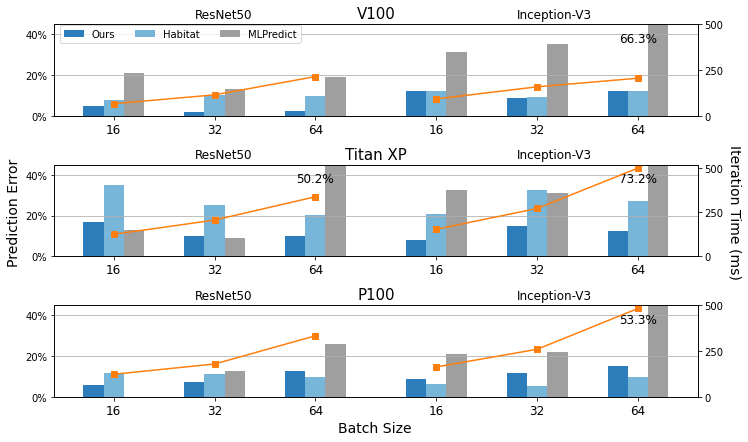

In [16]:
batch_sizes = [16, 32, 64]
tags = ["Ours", "Habitat", "MLPredict"]
other_errors = {
    "V100": {
        "ResNet50": [[5.0, 8.0, 21.2], [1.7, 10.1, 13.2], [2.2, 9.8, 19.2]],
        "Inception-V3": [[12.4, 12.0, 31.6], [9.0, 9.3, 35.2], [12.4, 12.3, 66.3]],
    },
    "Titan XP": {
        "ResNet50": [[16.8, 34.9, 12.9], [10.1, 25.4, 9.0], [10.0, 20.3, 50.2]],
        "Inception-V3": [[7.8, 21.0, 32.6], [15.0, 32.4, 31.1], [12.2, 27.4, 73.2]],
    },
    "P100": {
        "ResNet50": [[5.8, 11.4, 0.0], [7.4, 11.3, 12.4], [12.8, 9.7, 25.7]],
        "Inception-V3": [[8.5, 6.0, 20.9], [11.7, 5.3, 22.1], [15.2, 9.6, 53.3]],
    }
}
other_time = {
    "V100": {
        "ResNet50": [66.55, 114.78, 214.53],
        "Inception-V3": [92.63, 158.75, 205.68],
    },
    "Titan XP": {
        "ResNet50": [125.07, 205.83, 338.41],
        "Inception-V3": [153.80, 272.07, 502.00],
    },
    "P100": {
        "ResNet50": [122.75, 179.16, 333.54],
        "Inception-V3": [163.00, 259.92, 483.89],
    }
}

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 6))
count = 0
model_gap = 3.2
yticks = [0, 20, 40]
yticks2 = [0, 250, 500]
yticklabels = ["{:.0f}%".format(x) for x in yticks]
for device, error in other_errors.items():
    ax = axes[count]
    ax2 = ax.twinx()
    e1 = []
    e2 = []
    e3 = []
    x1 = []
    x2 = []
    x3 = []
    c = 0
    for model, e in error.items():
        xtt = []
        c += 0.5
        cc = 0
        for ee in e:
            e1.append(ee[0])
            e2.append(ee[1])
            e3.append(ee[2])
            x1.append(model_gap * c - 2 + cc - 0.1)
            x2.append(model_gap * c - 2 + cc)
            x3.append(model_gap * c - 2 + cc + 0.1)
            cc += 0.5

            xtt.append(model_gap * c - 2 + cc - 0.5)

        ax.text(model_gap * c - 1.6, yticks[-1]+8, model, fontsize=12, transform=ax.transData)

        ax2.plot(xtt, other_time[device][model], color=plt.get_cmap("tab10")(1), marker="s")

    ax.bar(x1, e1, width=0.1, color=plt.get_cmap("Blues")(180), label=tags[0])
    ax.bar(x2, e2, width=0.1, color=plt.get_cmap("Blues")(120), label=tags[1])
    ax.bar(x3, e3, width=0.1, color=plt.get_cmap("Greys")(120), label=tags[2])
    ax.grid(axis='y')
    ax.set_xticks([(x+y)/2 for x,y in zip(x1,x3)])
    ax.set_xticklabels(batch_sizes + batch_sizes, fontsize=12)
    ax.set_title(device, fontsize=15)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylim(0, yticks[-1]+5)
    for xe in [zip(x1, e1), zip(x2, e2), zip(x3, e3)]:
        for x, e in xe:
            if e > yticks[-1]+5:
                ax.text(x-0.1, yticks[-1]-2, "{:.1f}%".format(e), horizontalalignment='center', verticalalignment='center', size=12)

    ax2.set_yticks(yticks2)

    count += 1
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc=[0.08, 0.9], ncol=3)
fig.text(-0.01, 0.5, 'Prediction Error', va='center', rotation=90, fontsize=14)
fig.text(0.99, 0.5, 'Iteration Time (ms)', va='center', rotation=-90, fontsize=14)
fig.text(0.45, -0.01, "Batch Size", fontsize=14)
plt.tight_layout()
plt.savefig('{}/data/e2e_others.pdf'.format(PM_HOME), bbox_inches='tight')
plt.savefig('{}/data/e2e_others.png'.format(PM_HOME), bbox_inches='tight')